In [1]:
from pytorch_lightning import Trainer
from lightning.pytorch.loggers import WandbLogger
from pytorch_lightning.strategies import DDPStrategy
from time import perf_counter
import wandb
import numpy as np

import torch
torch.set_float32_matmul_precision('medium')

from src.algorithms.unrolling_policy_iteration import UnrollingPolicyIterationTrain
from src.environments import CliffWalkingEnv
from src.algorithms.generalized_policy_iteration import PolicyIterationTrain
from src.utils import get_optimal_q, test_pol_err, plot_errors

SAVE = True
PATH = "results/n_unrolls/"

## Auxiliary functions

In [2]:
def run(g, N_unrolls, Exps, q_opt, group_name, use_logger=True, log_every_n_steps=1, verbose=False):
    err1 = np.zeros((len(Exps), N_unrolls.size))
    err2 = np.zeros((len(Exps), N_unrolls.size))
    bell_err = np.zeros((len(Exps), N_unrolls.size))
    
    use_logger = use_logger and g == 0

    for i, n_unrolls in enumerate(N_unrolls):
        n_unrolls = int(n_unrolls)
        for j, exp in enumerate(Exps):
            env = CliffWalkingEnv()

            if exp["model"] == "unroll":
                model = UnrollingPolicyIterationTrain(env=env, env_test=env, num_unrolls=n_unrolls, **exp["args"])
                if use_logger:
                    logger = WandbLogger(project="rl-unrolling", name=f"{exp['name']}-{n_unrolls}unrolls",
                                         group=group_name)
                else:
                    logger = False
                trainer = Trainer(max_epochs=3000, log_every_n_steps=log_every_n_steps, accelerator="cpu", logger=logger)

            elif exp["model"] == "pol-it":
                model = PolicyIterationTrain(env=env, **exp["args"])
                if use_logger:
                    logger = WandbLogger(project="rl-unrolling", name=f"{exp['name']}-{n_unrolls}impr",
                                         group=group_name)
                else:
                    logger = False
                trainer = Trainer(max_epochs=n_unrolls, log_every_n_steps=log_every_n_steps, accelerator='cpu', logger=logger)
            else:
                raise Exception("Unknown model")

            trainer.fit(model)
            wandb.finish()

            err1[j,i], err2[j,i] = test_pol_err(model, q_opt)
            bell_err[j,i] = model.bellman_error.cpu().numpy()

            if verbose:
                print(f"- {g}. Unrolls {n_unrolls}: Model: {exp["name"]} Err1: {err1[j,i]:.3f} | bell_err: {bell_err[j,i]:.3f}")
    return err1, err2, bell_err


## K = 5

In [ ]:
verbose = True
use_logger = True
log_every_n_steps = 1
K = 5
group_name = f"n_unrolls-K{K}"

N_unrolls = np.arange(2,11, 2)
Exps = [
    {"model": "pol-it", "args": {"max_eval_iters": 1}, "fmt": "^-", "name": "val-it"},
    {"model": "pol-it", "args": {"max_eval_iters": K}, "fmt": "x-", "name": f"pol-it-{K}eval"},

    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-K{K}-WS"},
    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o--", "name": f"unr-K{K}"},
]

q_opt = get_optimal_q(use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


n_unrolls-K5


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
wandb: Currently logged in as: samuel-rey (samuel-rey-lab) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 17:   0%|          | 0/1 [00:00<?, ?it/s, v_num=204y, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]             

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 160.38it/s, v_num=204y, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 107.15it/s, v_num=204y, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
policy_diff,█▆▅▅▅▄▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
q_norm,█▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
bellman_error,0
epoch,49
policy_diff,0
q_norm,708.56281
trainer/global_step,49


In [ ]:
n_runs = 15

errs1 = np.zeros((n_runs, len(Exps), N_unrolls.size))
errs2 = np.zeros((n_runs, len(Exps), N_unrolls.size))
bell_errs = np.zeros((n_runs, len(Exps), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs1[g], errs2[g], bell_errs[g] = run(g, N_unrolls, Exps, q_opt, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps, errs1=errs1, errs2=errs2, bell_errs=bell_errs)
    print("Data saved as:", file_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 216.47it/s, v_num=sfz2, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 124.27it/s, v_num=sfz2, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁
epoch,▁█
policy_diff,█▁
q_norm,▁█
trainer/global_step,▁██
bellman_error,0.02096
epoch,1
policy_diff,2
q_norm,631.14526
trainer/global_step,1


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 179.83it/s, v_num=q6aj, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 103.92it/s, v_num=q6aj, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0]

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


bellman_error,█▁
epoch,▁█
policy_diff,█▁
q_norm,█▁
trainer/global_step,▁██
bellman_error,0.01657
epoch,1
policy_diff,5.09902
q_norm,702.45593
trainer/global_step,1


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


- 0. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017


/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=167` in the `DataLoader` to improve performance.


Epoch 657: 100%|██████████| 1/1 [00:00<00:00, 173.73it/s, v_num=rjdm, reward_smoothness=0.980, bellman_error=25.10, loss=3.270] 

In [3]:
# Load data
data = np.load(PATH + "n_unrolls-K5_data.npz", allow_pickle=True)
N_unrolls = data["N_unrolls"]
Exps = data["Exps"]
errs1 = data["errs1"]
errs2 = data["errs2"]
bell_errs = data["bell_errs"]

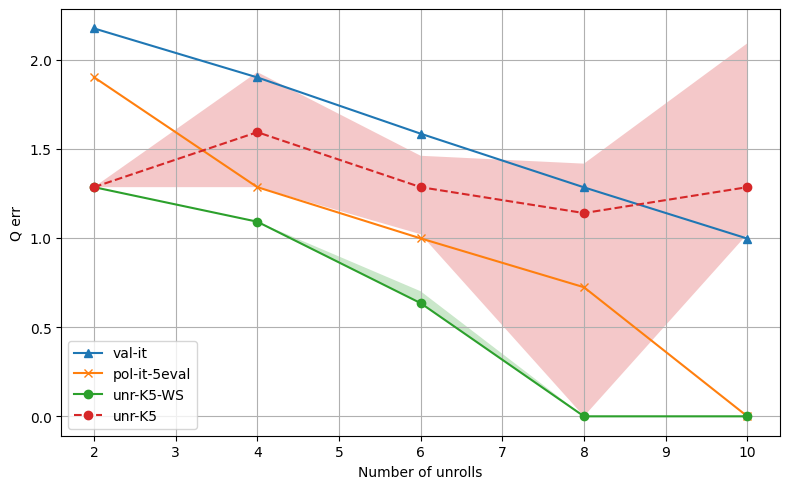

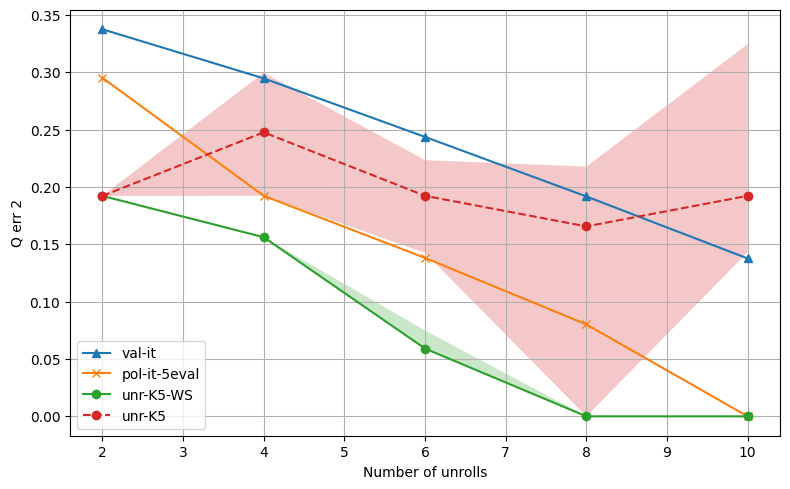

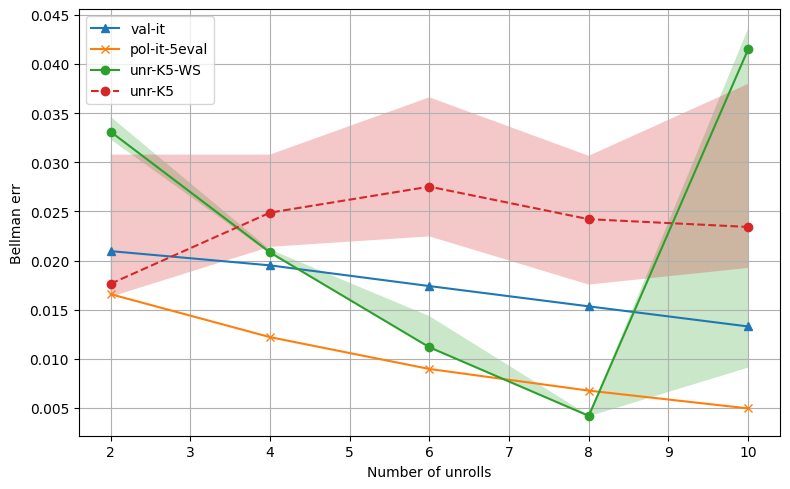

In [4]:
skip_idx = []
xlabel = "Number of unrolls"
plot_errors(errs1, N_unrolls, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, N_unrolls, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## K=10

In [ ]:
verbose = True
use_logger = True
log_every_n_steps = 1
K = 10
group_name = f"n_unrolls-K{K}"
N_unrolls = np.arange(2,11, 2)
Exps = [
    {"model": "pol-it", "args": {"max_eval_iters": 1}, "fmt": "^-", "name": "val-it"},
    {"model": "pol-it", "args": {"max_eval_iters": K}, "fmt": "x-", "name": f"pol-it-{K}eval"},
    # {"model": "pol-it", "args": {"max_eval_iters": 20}, "name": "pol-it-20eval"},

    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-K{K}-WS"},
    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o--", "name": f"unr-K{K}"},
]

q_opt = get_optimal_q(use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/srey/Investigacion/rl-unrolling/checkpoints exists and is not empty.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in 

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 215.09it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]    

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 215.85it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 120.88it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]


In [ ]:
n_runs = 15

errs1 = np.zeros((n_runs, len(Exps), N_unrolls.size))
errs2 = np.zeros((n_runs, len(Exps), N_unrolls.size))
bell_errs = np.zeros((n_runs, len(Exps), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs1[g], errs2[g], bell_errs[g] = run(g, N_unrolls, Exps, q_opt, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps, errs1=errs1, errs2=errs2, bell_errs=bell_errs)
    print("Data saved as:", file_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 234.20it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 110.88it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 196.91it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 98.52it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 195.00it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 99.05it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICE

- 0. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 92.52it/s, reward_smoothness=0.980, bellman_error=26.50, loss=3.650] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 58.72it/s, reward_smoothness=0.980, bellman_error=26.50, loss=3.650]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 2: Model: unr-K5-WS Err1: 1.285 | bell_err: 0.035
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 81.82it/s, reward_smoothness=0.980, bellman_error=14.00, loss=1.020] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 54.24it/s, reward_smoothness=0.980, bellman_error=14.00, loss=1.020]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K10-WS Err1: 2.217 | bell_err: 0.017
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 242.92it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 105.46it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 5: Model: val-it Err1: 1.740 | bell_err: 0.018
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 236.97it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 103.38it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 5: Model: pol-it-5eval Err1: 1.139 | bell_err: 0.010
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 225.32it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 95.39it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 0. Unrolls 5: Model: pol-it-10eval Err1: 1.432 | bell_err: 0.005
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 67.19it/s, reward_smoothness=0.980, bellman_error=17.30, loss=1.570] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 46.69it/s, reward_smoothness=0.980, bellman_error=17.30, loss=1.570]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 5: Model: unr-K5-WS Err1: 0.950 | bell_err: 0.019
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 48.87it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.930]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 36.40it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.930]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 5: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.021
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 246.72it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 108.05it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 10: Model: val-it Err1: 0.996 | bell_err: 0.013
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 241.48it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 107.28it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: pol-it-5eval Err1: 0.000 | bell_err: 0.005
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 237.77it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 105.76it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


- 0. Unrolls 10: Model: pol-it-10eval Err1: 0.723 | bell_err: 0.002



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 43.75it/s, reward_smoothness=0.980, bellman_error=12.10, loss=0.764] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 31.60it/s, reward_smoothness=0.980, bellman_error=12.10, loss=0.764]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 10: Model: unr-K5-WS Err1: 0.000 | bell_err: 0.013
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 34.82it/s, reward_smoothness=0.980, bellman_error=5.370, loss=0.150]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 26.67it/s, reward_smoothness=0.980, bellman_error=5.370, loss=0.150]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.006
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 181.72it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 94.28it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 190.42it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 96.82it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 183.43it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 94.19it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 1. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 98.81it/s, reward_smoothness=0.980, bellman_error=37.00, loss=7.140] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 64.58it/s, reward_smoothness=0.980, bellman_error=37.00, loss=7.140]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 2: Model: unr-K5-WS Err1: 1.909 | bell_err: 0.044
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 86.86it/s, reward_smoothness=0.980, bellman_error=13.40, loss=0.942] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 57.59it/s, reward_smoothness=0.980, bellman_error=13.40, loss=0.942]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: unr-K10-WS Err1: 0.128 | bell_err: 0.016
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 242.91it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 99.46it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 5: Model: val-it Err1: 1.740 | bell_err: 0.018
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 239.77it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 98.17it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 5: Model: pol-it-5eval Err1: 1.139 | bell_err: 0.010
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 237.56it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 97.36it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 1. Unrolls 5: Model: pol-it-10eval Err1: 1.432 | bell_err: 0.005
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 68.63it/s, reward_smoothness=0.980, bellman_error=14.30, loss=1.060] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 46.74it/s, reward_smoothness=0.980, bellman_error=14.30, loss=1.060]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 5: Model: unr-K5-WS Err1: 0.813 | bell_err: 0.016
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.940]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 37.27it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.940]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 5: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.021
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 240.09it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 112.71it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 10: Model: val-it Err1: 0.996 | bell_err: 0.013
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 227.77it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 101.83it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 10: Model: pol-it-5eval Err1: 0.000 | bell_err: 0.005
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 225.14it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 101.66it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


- 1. Unrolls 10: Model: pol-it-10eval Err1: 0.723 | bell_err: 0.002


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 45.66it/s, reward_smoothness=0.980, bellman_error=47.90, loss=12.00]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s, reward_smoothness=0.980, bellman_error=47.90, loss=12.00]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 10: Model: unr-K5-WS Err1: 0.000 | bell_err: 0.044
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 31.29it/s, reward_smoothness=0.980, bellman_error=25.80, loss=3.460]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s, reward_smoothness=0.980, bellman_error=25.80, loss=3.460]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 10: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.025
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 182.56it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 93.88it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 2. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 190.27it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 95.97it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 2. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 185.92it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 95.43it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 2. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009
Epoch 1734:   0%|          | 0/1 [00:00<?, ?it/s, reward_smoothness=0.980, bellman_error=14.80, loss=1.150]         

In [ ]:
# # Load data
# data = np.load(PATH + "n_unrolls-K10_data.npz", allow_pickle=True)
# N_unrolls = data["N_unrolls"]
# Exps = data["Exps"]
# errs1 = data["errs1"]
# errs2 = data["errs2"]
# bell_errs = data["bell_errs"]

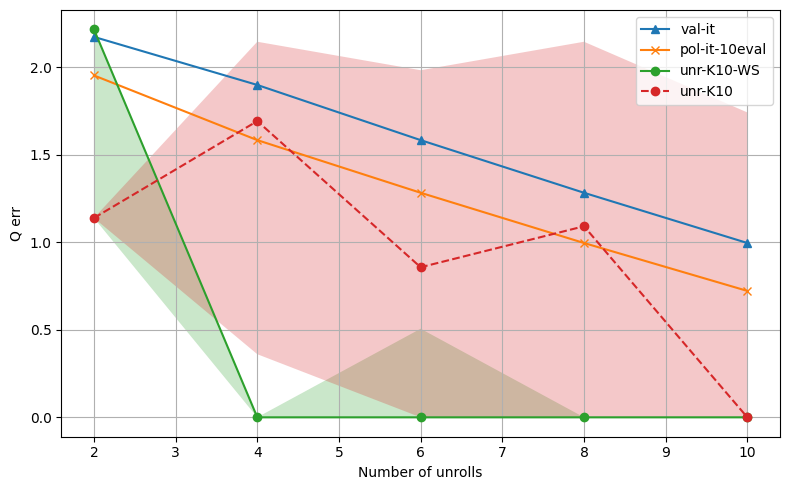

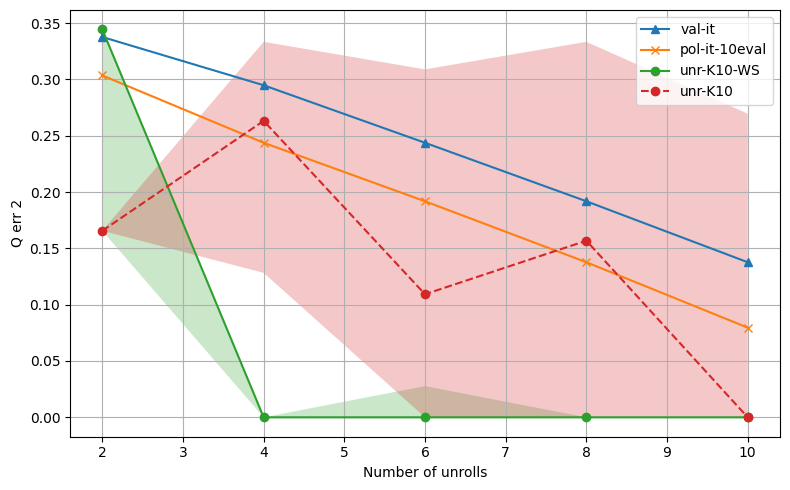

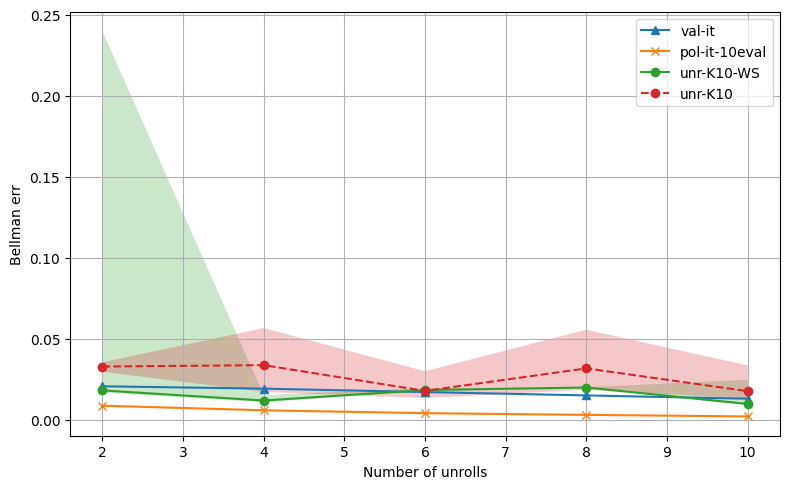

In [6]:
skip_idx = []
xlabel = "Number of unrolls"
plot_errors(errs1, N_unrolls, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, N_unrolls, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## K=15

In [ ]:
verbose = True
use_logger = False
log_every_n_steps = 1
K = 15
group_name = f"n_unrolls-K{K}"
N_unrolls = np.arange(2,11, 2)
Exps = [
    {"model": "pol-it", "args": {"max_eval_iters": 1}, "fmt": "^-", "name": "val-it"},
    {"model": "pol-it", "args": {"max_eval_iters": K}, "fmt": "x-", "name": f"pol-it-{K}eval"},
    # {"model": "pol-it", "args": {"max_eval_iters": 20}, "name": "pol-it-20eval"},

    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": True}, "fmt": "o-", "name": f"unr-K{K}-WS"},
    {"model": "unroll", "args": {"K": K, "tau": 5, "lr": 5e-3, "weight_sharing": False}, "fmt": "o--", "name": f"unr-K{K}"},
]

q_opt = get_optimal_q(use_logger=use_logger, log_every_n_steps=log_every_n_steps, group_name=group_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:658: Checkpoint directory /home/srey/Investigacion/rl-unrolling/checkpoints exists and is not empty.
/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/core/optimizer.py:183: `LightningModule.configure_optimizers` returned `None`, this fit will run with no optimizer

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in 

Epoch 14: 100%|██████████| 1/1 [00:00<00:00, 215.09it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]    

/home/srey/Investigacion/rl-unrolling/.venv/lib/python3.12/site-packages/pytorch_lightning/loops/optimization/automatic.py:134: `training_step` returned `None`. If this was on purpose, ignore this warning...


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 215.85it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 1/1 [00:00<00:00, 120.88it/s, bellman_error=0.000, policy_diff=0.000, q_norm=709.0]


In [ ]:
n_runs = 15

errs1 = np.zeros((n_runs, len(Exps), N_unrolls.size))
errs2 = np.zeros((n_runs, len(Exps), N_unrolls.size))
bell_errs = np.zeros((n_runs, len(Exps), N_unrolls.size))

t_init = perf_counter()
for g in range(n_runs):
    errs1[g], errs2[g], bell_errs[g] = run(g, N_unrolls, Exps, q_opt, group_name, use_logger, log_every_n_steps, verbose)

t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')

if SAVE:
    file_name = PATH + f"{group_name}_data.npz"
    np.savez(file_name, N_unrolls=N_unrolls, Exps=Exps, errs1=errs1, errs2=errs2, bell_errs=bell_errs)
    print("Data saved as:", file_name)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 234.20it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 110.88it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 196.91it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 98.52it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 195.00it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 99.05it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICE

- 0. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 92.52it/s, reward_smoothness=0.980, bellman_error=26.50, loss=3.650] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 58.72it/s, reward_smoothness=0.980, bellman_error=26.50, loss=3.650]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 2: Model: unr-K5-WS Err1: 1.285 | bell_err: 0.035
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 81.82it/s, reward_smoothness=0.980, bellman_error=14.00, loss=1.020] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 54.24it/s, reward_smoothness=0.980, bellman_error=14.00, loss=1.020]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 2: Model: unr-K10-WS Err1: 2.217 | bell_err: 0.017
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 242.92it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 105.46it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 5: Model: val-it Err1: 1.740 | bell_err: 0.018
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 236.97it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 103.38it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 5: Model: pol-it-5eval Err1: 1.139 | bell_err: 0.010
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 225.32it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 95.39it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 0. Unrolls 5: Model: pol-it-10eval Err1: 1.432 | bell_err: 0.005
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 67.19it/s, reward_smoothness=0.980, bellman_error=17.30, loss=1.570] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 46.69it/s, reward_smoothness=0.980, bellman_error=17.30, loss=1.570]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 5: Model: unr-K5-WS Err1: 0.950 | bell_err: 0.019
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 48.87it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.930]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 36.40it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.930]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 5: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.021
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 246.72it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 108.05it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 0. Unrolls 10: Model: val-it Err1: 0.996 | bell_err: 0.013
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 241.48it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 107.28it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: pol-it-5eval Err1: 0.000 | bell_err: 0.005
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 237.77it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 105.76it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


- 0. Unrolls 10: Model: pol-it-10eval Err1: 0.723 | bell_err: 0.002



  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 43.75it/s, reward_smoothness=0.980, bellman_error=12.10, loss=0.764] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 31.60it/s, reward_smoothness=0.980, bellman_error=12.10, loss=0.764]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 0. Unrolls 10: Model: unr-K5-WS Err1: 0.000 | bell_err: 0.013
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 34.82it/s, reward_smoothness=0.980, bellman_error=5.370, loss=0.150]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 26.67it/s, reward_smoothness=0.980, bellman_error=5.370, loss=0.150]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 0. Unrolls 10: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.006
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 181.72it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 94.28it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 190.42it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 96.82it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 183.43it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 94.19it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 1. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 98.81it/s, reward_smoothness=0.980, bellman_error=37.00, loss=7.140] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 64.58it/s, reward_smoothness=0.980, bellman_error=37.00, loss=7.140]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 2: Model: unr-K5-WS Err1: 1.909 | bell_err: 0.044
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 86.86it/s, reward_smoothness=0.980, bellman_error=13.40, loss=0.942] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 57.59it/s, reward_smoothness=0.980, bellman_error=13.40, loss=0.942]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 2: Model: unr-K10-WS Err1: 0.128 | bell_err: 0.016
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 242.91it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 99.46it/s, bellman_error=0.0184, policy_diff=2.450, q_norm=651.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 5: Model: val-it Err1: 1.740 | bell_err: 0.018
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 239.77it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 98.17it/s, bellman_error=0.0103, policy_diff=3.160, q_norm=793.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 5: Model: pol-it-5eval Err1: 1.139 | bell_err: 0.010
Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 237.56it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 1/1 [00:00<00:00, 97.36it/s, bellman_error=0.00518, policy_diff=4.240, q_norm=1.09e+3] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 1. Unrolls 5: Model: pol-it-10eval Err1: 1.432 | bell_err: 0.005
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 68.63it/s, reward_smoothness=0.980, bellman_error=14.30, loss=1.060] 

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 46.74it/s, reward_smoothness=0.980, bellman_error=14.30, loss=1.060]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 5: Model: unr-K5-WS Err1: 0.813 | bell_err: 0.016
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 50.73it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.940]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 37.27it/s, reward_smoothness=0.980, bellman_error=19.30, loss=1.940]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 5: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.021
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 240.09it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 112.71it/s, bellman_error=0.0133, policy_diff=2.450, q_norm=685.0]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 1. Unrolls 10: Model: val-it Err1: 0.996 | bell_err: 0.013
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 227.77it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 101.83it/s, bellman_error=0.00494, policy_diff=2.450, q_norm=891.0]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 10: Model: pol-it-5eval Err1: 0.000 | bell_err: 0.005
Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 225.14it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 1/1 [00:00<00:00, 101.66it/s, bellman_error=0.00236, policy_diff=2.450, q_norm=1.14e+3]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


- 1. Unrolls 10: Model: pol-it-10eval Err1: 0.723 | bell_err: 0.002


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params
0         Non-trainable params
12        Total params
0.000     Total estimated model params size (MB)
44        Modules in train mode
0         Modules in eval mode


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 45.66it/s, reward_smoothness=0.980, bellman_error=47.90, loss=12.00]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 32.48it/s, reward_smoothness=0.980, bellman_error=47.90, loss=12.00]
P_pi is NOT diagonalizable


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 11     | train
1 | model_test | UnrolledPolicyIterationModel | 11     | train
--------------------------------------------------------------------
22        Trainable params


- 1. Unrolls 10: Model: unr-K5-WS Err1: 0.000 | bell_err: 0.044
Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 31.29it/s, reward_smoothness=0.980, bellman_error=25.80, loss=3.460]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 24.63it/s, reward_smoothness=0.980, bellman_error=25.80, loss=3.460]
P_pi is NOT diagonalizable


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 1. Unrolls 10: Model: unr-K10-WS Err1: 0.000 | bell_err: 0.025
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 182.56it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0]

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 93.88it/s, bellman_error=0.021, policy_diff=2.000, q_norm=631.0] 

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode



- 2. Unrolls 2: Model: val-it Err1: 2.175 | bell_err: 0.021
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 190.27it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 95.97it/s, bellman_error=0.0166, policy_diff=5.100, q_norm=702.0] 


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name | Type | Params | Mode
-------------------------------------
-------------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


- 2. Unrolls 2: Model: pol-it-5eval Err1: 1.901 | bell_err: 0.017
Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 185.92it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 

`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 95.43it/s, bellman_error=0.00898, policy_diff=5.480, q_norm=951.0] 


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                         | Params | Mode 
--------------------------------------------------------------------
0 | model      | UnrolledPolicyIterationModel | 6      | train
1 | model_test | UnrolledPolicyIterationModel | 6      | train
--------------------------------------------------------------------
12        Trainable params


- 2. Unrolls 2: Model: pol-it-10eval Err1: 1.954 | bell_err: 0.009
Epoch 1734:   0%|          | 0/1 [00:00<?, ?it/s, reward_smoothness=0.980, bellman_error=14.80, loss=1.150]         

In [ ]:
# # Load data
# data = np.load(PATH + "n_unrolls-K15_data.npz", allow_pickle=True)
# N_unrolls = data["N_unrolls"]
# Exps = data["Exps"]
# errs1 = data["errs1"]
# errs2 = data["errs2"]
# bell_errs = data["bell_errs"]

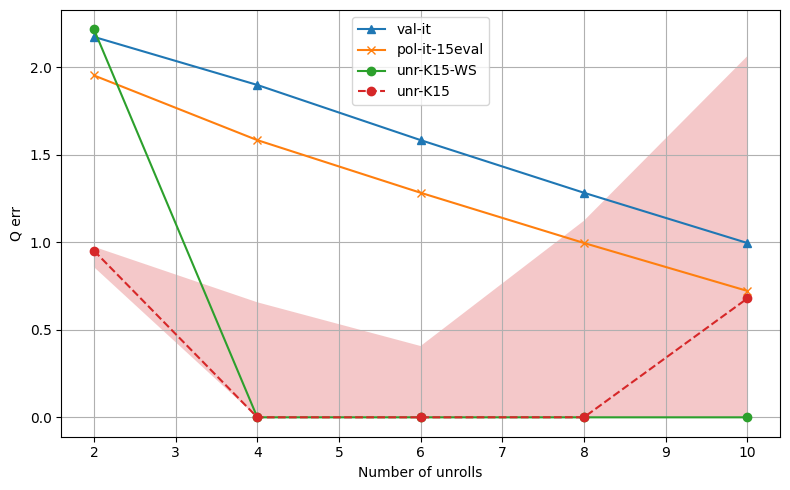

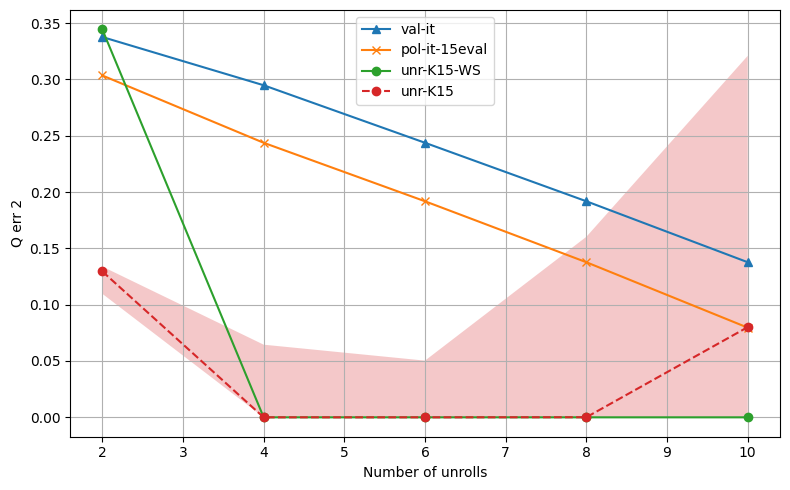

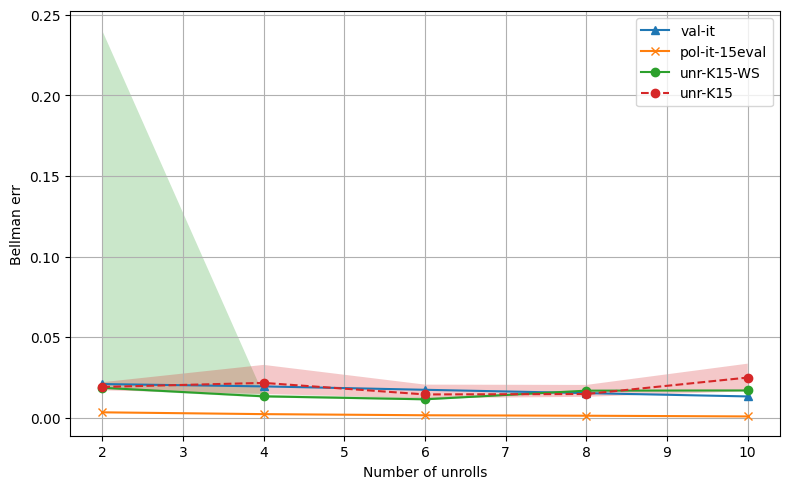

In [10]:
skip_idx = []
xlabel = "Number of unrolls"
plot_errors(errs1, N_unrolls, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, N_unrolls, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')


## Plot All

In [13]:
# Load data
files = ["n_unrolls-K5_data.npz", "n_unrolls-K10_data.npz", "n_unrolls-K15_data.npz"]

Exps = []
errs1_list = []
errs2_list = []
bell_errs_list = []
for file in files:
    data = np.load(PATH + file, allow_pickle=True)
    
    if 'N_unrolls' not in locals():  # Save only once
        N_unrolls = data["N_unrolls"]
    
    Exps += list(data["Exps"])
    
    errs1_list.append(data["errs1"])
    errs2_list.append(data["errs2"])
    bell_errs_list.append(data["bell_errs"])

# Concatenate all data
errs1 = np.concatenate(errs1_list, axis=1)
errs2 = np.concatenate(errs2_list, axis=1)
bell_errs = np.concatenate(bell_errs_list, axis=1)

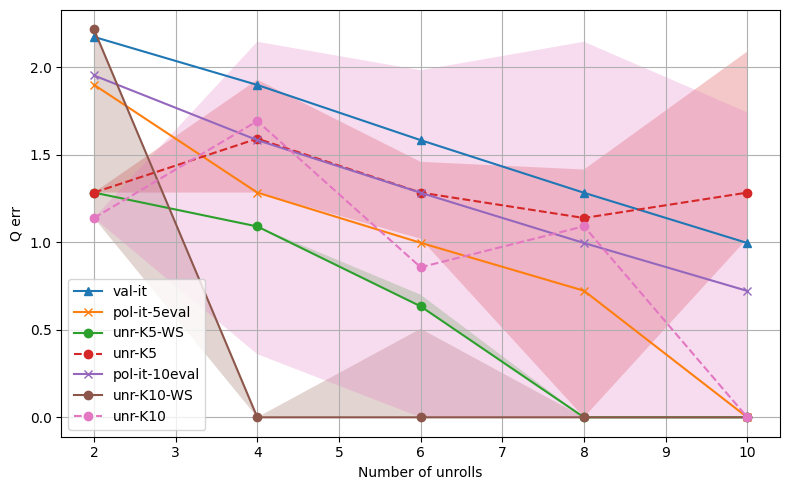

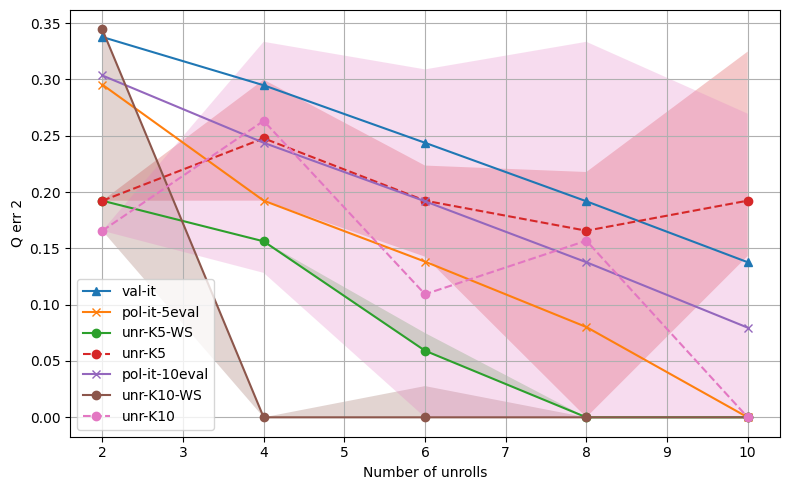

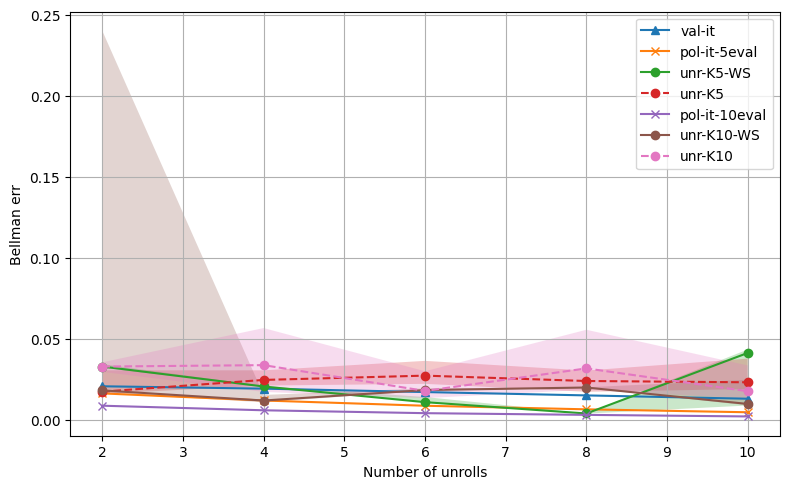

In [18]:
# Indexes 0, 4 and 8 are all policy evaluation
skip_idx = [4, 8, 9, 10, 11]
xlabel = "Number of unrolls"
plot_errors(errs1, N_unrolls, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, N_unrolls, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')

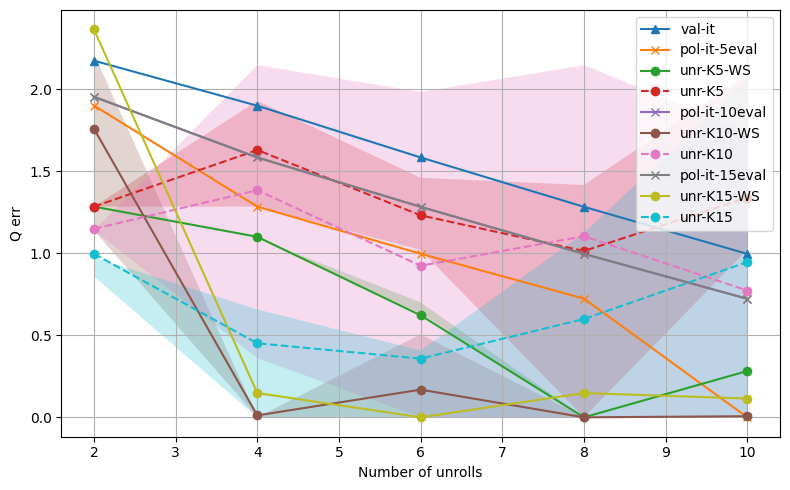

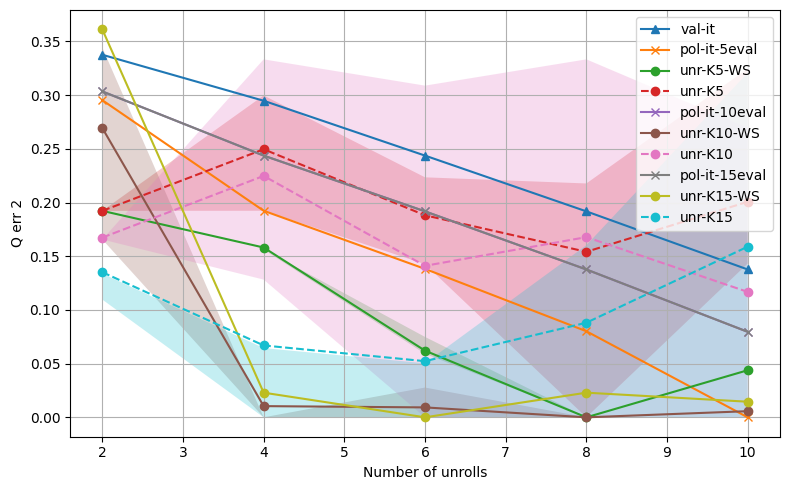

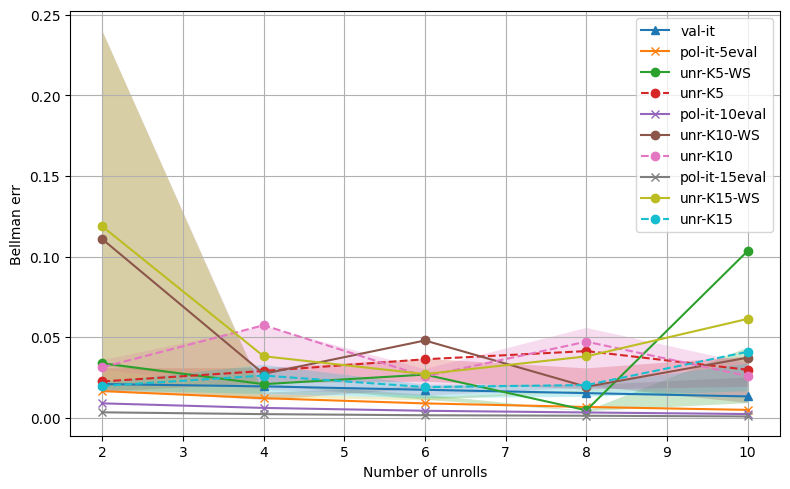

In [ ]:
# Indexes 0, 4 and 8 are all policy evaluation
skip_idx = [4, 8]
xlabel = "Number of unrolls"
plot_errors(errs1, N_unrolls, Exps, xlabel, "Q err", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(errs2, N_unrolls, Exps, xlabel, "Q err 2", skip_idx=skip_idx, agg="median", deviation='prctile')
plot_errors(bell_errs, N_unrolls, Exps, xlabel, "Bellman err", skip_idx=skip_idx, agg="median", deviation='prctile')